In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import wfdb
import pandas as pd

In [2]:
#Read binary data file

record = wfdb.rdrecord('/home/bechorfa/Downloads/patho/FL001') 
display(record.__dict__)

{'record_name': 'FL001',
 'n_sig': 6,
 'fs': 100,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 24542514,
 'base_time': None,
 'base_date': None,
 'comments': ['Age:79.2', 'Sex:M'],
 'sig_name': ['v-acceleration',
  'ml-acceleration',
  'ap-acceleration',
  'yaw-velocity',
  'pitch-velocity',
  'roll-velocity'],
 'p_signal': array([[  0.15161927,   0.2463004 ,  -1.01169028,  -6.65615068,
         -31.49559987, -12.78891854],
        [  0.12423455,   0.26350916,  -1.03307087,  -9.03531198,
         -26.9265502 ,  -4.59867185],
        [  0.06562889,   0.25203665,  -1.01266213,  -9.66104515,
         -19.36645858,   4.80494472],
        ...,
        [  0.15067497,   0.94259795,  -0.33589381,   0.59822842,
           1.26957895,   5.33882747],
        [  0.14973067,   0.94259795,  -0.33589381,   0.47445702,
           1.31978829,   5.32669377],
        [  0.14973067,   0.94451004,  -0.33692639,   0.44695227,
           1.34847934,   5.32669377]]),
 'd_signal': None,
 'e_p_sign

In [3]:
#Separating the three accelerometer axes  

#Vertical acc
v_acc, fields = wfdb.rdsamp('/home/bechorfa/Downloads/patho/FL001', channels=[0])

#Mediolateral acc
ml_acc, fields = wfdb.rdsamp('/home/bechorfa/Downloads/patho/FL001', channels=[1])

#Anterior-Posterior acc
ap_acc, fields = wfdb.rdsamp('/home/bechorfa/Downloads/patho/FL001', channels=[2])

In [4]:
#Creating dataFrame from every axis of the three above

acc_x = pd.DataFrame(v_acc, columns=["vertical"])
acc_y = pd.DataFrame(ml_acc, columns=["mediolateral"])
acc_z = pd.DataFrame(ap_acc, columns=["anterior-posterior"])

#Concatinate the three dataFrames created & giving column convinient names

df = pd.concat([acc_x, acc_y, acc_z], axis=1, ignore_index=True)
df = df.rename(columns={0: "v-acceleration", 1: "ml-acceleration", 2:"ap-acceleration"})


In [5]:
#Creating new tmp column (choosen rate 10 ms per sample)

tmp = []
for i in range (len(df)):
    tmp.append(10*i)

df.insert(0, 't ms', tmp)

df

,t ms,v-acceleration,ml-acceleration,ap-acceleration
0,0,0.151619,0.246300,-1.011690
1,10,0.124235,0.263509,-1.033071
2,20,0.065629,0.252037,-1.012662
3,30,0.047687,0.171669,-0.978587
4,40,0.047687,0.201307,-0.964981
...,...,...,...,...
24542509,245425090,0.150675,0.943554,-0.336926
24542510,245425100,0.150675,0.942598,-0.335894
24542511,245425110,0.150675,0.942598,-0.335894
24542512,245425120,0.149731,0.942598,-0.335894


In [6]:
df["mean"] = df.iloc[:,1:4].mean(axis="columns")
df["mag"]=np.sqrt(np.square(df.iloc[:,1:4]).sum(axis=1))
df

,t ms,v-acceleration,ml-acceleration,ap-acceleration,mean,mag
0,0,0.151619,0.246300,-1.011690,-0.204590,1.052221
1,10,0.124235,0.263509,-1.033071,-0.215109,1.073362
2,20,0.065629,0.252037,-1.012662,-0.231666,1.045617
3,30,0.047687,0.171669,-0.978587,-0.253077,0.994674
4,40,0.047687,0.201307,-0.964981,-0.238662,0.986908
...,...,...,...,...,...,...
24542509,245425090,0.150675,0.943554,-0.336926,0.252434,1.013171
24542510,245425100,0.150675,0.942598,-0.335894,0.252460,1.011938
24542511,245425110,0.150675,0.942598,-0.335894,0.252460,1.011938
24542512,245425120,0.149731,0.942598,-0.335894,0.252145,1.011798


In [7]:
#Slicing our data to 42 part each part represent a day with around 3h15min/day of record (6 weeks)

df_days = []

for i in range(21):
    if (i<20):
        df_days.append(df[(int(len(df)/21))*i:(int(len(df)/21))*(i+1)])
    else:
        df_days.append(df[(int(len(df)/21))*i:len(df)])
        

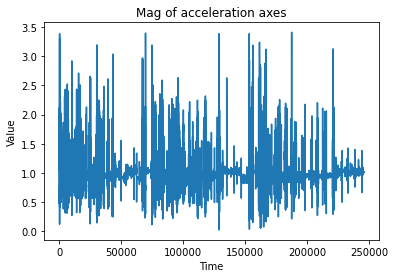

In [8]:
plt.plot(df["t ms"]/1000, df["mag"])
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Mag of acceleration axes")
plt.show()

In [9]:
#Autocorelation function

def autocorr(x,lags):
    '''manualy compute, non partial'''

    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/(len(x)-l)/var for l in lags]

    return np.array(corr)

In [10]:
def sliding_window(elements, window_size, all_windows):
    bound = int(len(elements)/(window_size/2))
    if len(elements) <= window_size:
       return elements
    for i in range(len(elements)):
        if (len(all_windows)==bound):
            break
        all_windows.append(np.array(elements[int(i*window_size/2):int(i*window_size/2)+window_size]))

In [41]:
windows = []
sliding_window(df["mag"], 200, windows)

In [100]:
std_windows = []
activity_1_2 = []
for i in windows:
    std_windows.append(np.std(i))
    if (np.std(i)> 0.1):
        activity_1_2.append(i)


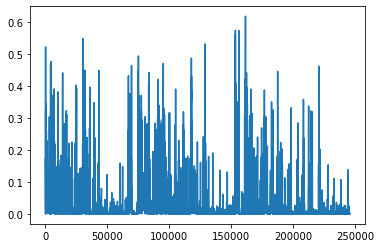

In [101]:
plt.plot(std_windows)
plt.show()

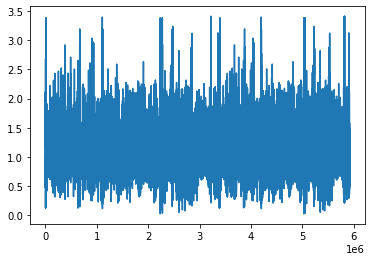

In [102]:
merged_1 = []  ##we merged all the signal of walking passed 1 filter
for i in activity_1_2: 
    for j in i:
        merged.append(j)

plt.plot(merged)
plt.show()

In [103]:
#Autocorelation function

def autocorr(x,lags):
    '''manualy compute, non partial'''

    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/(len(x)-l)/var for l in lags]

    return np.array(corr)

In [104]:

import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array
def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
    if x is None:
        x = arange(len(v))
    v = asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    lookformax = True
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
    return array(maxtab)

In [105]:
afcs = []
activity_2_2 = []
for i in activity_1_2:
    afcs.append(autocorr(np.array(i), np.arange(0,len(i))))
    

In [106]:
peaks = []
for i in afcs:
    peaks.append(peakdet(i,1))


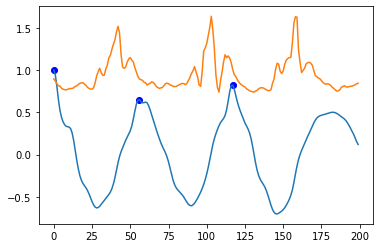

In [107]:
plt.plot(afcs[250])
plt.plot(activity_1_2[250])
plt.scatter(peaks[250][:,0], peaks[250][:,1], color='blue')
plt.show()

In [108]:
count = 0;
peaks_wlk = []
afcs_wlk = []
activity_2_2 = []
for i in peaks:
    if len(i) > 2:
        # marche 2/2 
        peaks_wlk.append(i)
        activity_2_2.append(activity_1_2[count])
        afcs_wlk.append(afcs[count])
    count+=1
## Add another level of filter (Non Max Supression)

In [109]:
merged_2 = []

for i in activity_2_2:
    for j in i:
        merged_2.append(j)

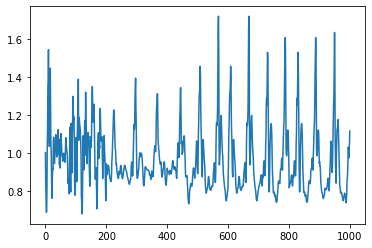

In [110]:
plt.plot(merged_2[:1000])
plt.show()

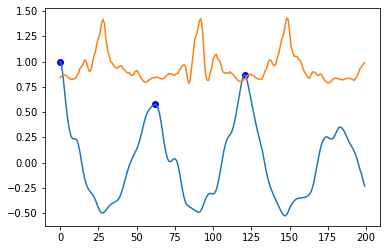

In [116]:
plt.plot(afcs_wlk[100])
plt.plot(activity_2_2[100])
plt.scatter(peaks_wlk[100][:,0], peaks_wlk[100][:,1], color='blue')
